In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
import skimage as sk
from scipy import misc

import cv2
from pylab import *
import torch
import torchvision
from torch import nn
from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import models
from torch import optim
from torch.utils.data import Dataset, DataLoader

import lovasz_losses as L

from tqdm import tqdm_notebook as tqdm

In [2]:
train_path = "/home/kaichou/ssd/salts/train"

In [3]:
train_df = pd.read_csv("/home/kaichou/ssd/salts/train.csv", index_col="id", usecols=[0])
depth_df = pd.read_csv("/home/kaichou/ssd/salts/depths.csv", index_col="id")
train_df = train_df.join(depth_df)
test_df = depth_df[~depth_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [plt.imread(os.path.join(train_path, f"images/{idx}.png")) for idx in tqdm(train_df.index)]

In [5]:
train_df["masks"] = [plt.imread(os.path.join(train_path, f"masks/{idx}.png")) for idx in tqdm(train_df.index)]

In [6]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return sk.transform.resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return sk.transform.resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [8]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [9]:
train_df.shape[0]

4000

Text(0.5,0,'Coverage class')

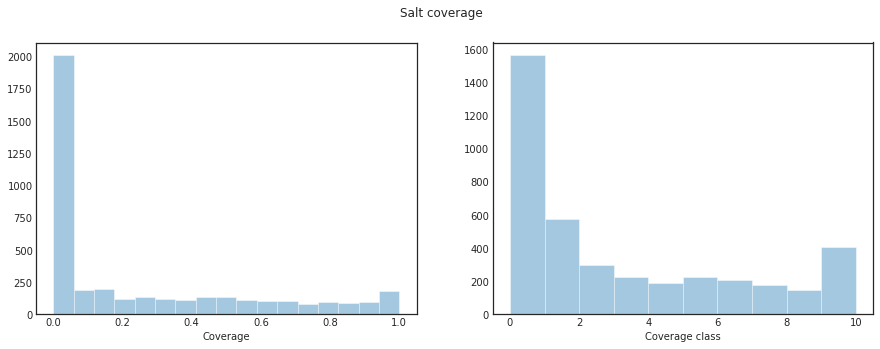

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

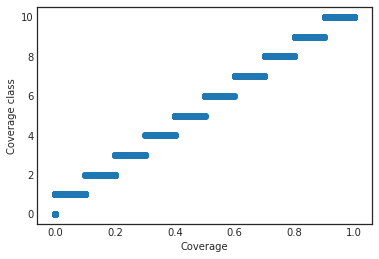

In [11]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

Text(0.5,1,'Depth distribution')

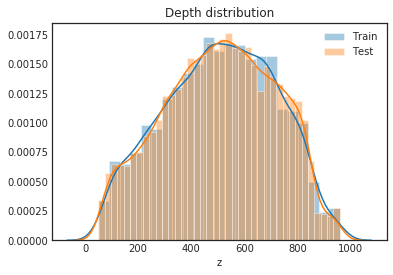

In [12]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

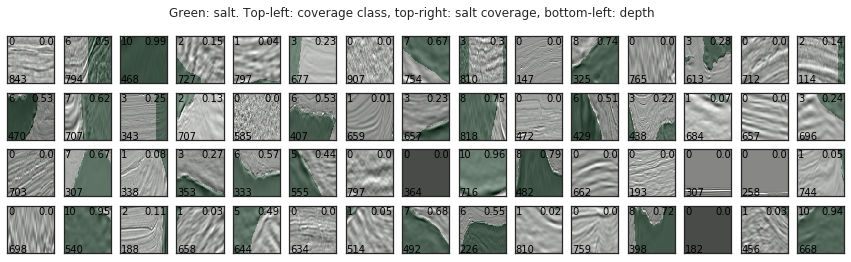

In [13]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [14]:
train_df.index

Index(['575d24d81d', 'a266a2a9df', '75efad62c1', '34e51dba6a', '4875705fb0',
       '782ae9b7e7', '9842f69f8d', 'aa94cfb806', '50d3073821', '28f865caaa',
       ...
       '633c7d5c80', '30082e87d9', 'f139be21a4', 'ac931ace49', 'cb36193e2f',
       '9cbd5ddba4', 'caa039b231', '1306fcee4c', '48d81e93d9', 'edf1e6ac00'],
      dtype='object', name='id', length=4000)

In [15]:
(sum(train_df["masks"]['575d24d81d']) <20) & (sum(train_df["masks"]['575d24d81d']) != 0)

False

In [16]:
for i in train_df.index:
    if (sum(train_df["masks"][i]) < 20) & (sum(train_df["masks"][i]) != 0):
        train_df = train_df.drop(i, axis=0)

In [17]:
for i in train_df.index:
    if (sum(train_df["masks"][i]) < 20) & (sum(train_df["masks"][i]) != 0):
        print(i)

In [18]:

print(train_df.images.shape)


(3931,)


In [19]:
np.shape(upsample(train_df.images[0]))

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(128, 128, 3)

In [20]:
np.shape(np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3))

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(3931, 128, 128, 3)

In [21]:
np.shape(np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1))

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(3931, 128, 128, 1)

In [22]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [30]:
del(x_train, x_valid, y_train, y_valid)

In [31]:
del(train_df)

In [33]:
import gc
gc.collect()

40

In [24]:
torch.cuda.is_available()

True

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x




class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out
    
def albunet(pretrained = False, **kwargs):

    model = AlbuNet(pretrained = pretrained)

    return model


In [27]:
def get_model():
    model = albunet(pretrained=True)
    model.train()
    return model.to(device)

In [28]:
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

In [29]:
def chw_to_hwc(img):
    return np.transpose(img, axes=[1, 2, 0])

In [35]:
class SaltsDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(f"/home/kaichou/ssd/salts/train/images/{ID}.png")
        x = upsample(x)
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        
        y = plt.imread(f"/home/kaichou/ssd/salts/train/masks/{ID}.png")
        y = upsample(y)
        y = torch.from_numpy(y)
        y = hwc_to_chw(y.float())
        return x, y
        

In [36]:
train_dataset = SaltsDataset(ids_train, x_train, y_train, device)
valid_dataset = SaltsDataset(ids_valid, x_valid, y_valid, device)

In [8]:
model = get_model()
model = model.cuda()

In [38]:
def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou

In [39]:
train_dataset.len

3144

In [40]:
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union + self.inter) \
                         / self.union * self.union
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

In [41]:
def jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1)
    union = y_true.sum(dim=-2).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1)

    return ((intersection + epsilon)/ (union - intersection + epsilon)).mean()

In [42]:
def eval_net(net, dataset, N_valid):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    tot = 0
    for x, y in dataset:
        x = x.cuda()
        y = y.cuda()

        mask_pred = net(x)
        mask_pred = (F.sigmoid(mask_pred) > 0.5).float()

        tot += jaccard(mask_pred.cpu(), y.cpu())
    return tot / N_valid

In [49]:
def train_model(net, train_dataset, valid_dataset, 
                epochs=200, batch_size=32, lr=0.001, save_cp=True, opti = "adam"):
    if opti == "adam":
        optimizer = optim.Adam(net.pparameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checkpoints/'
    criterion = nn.BCELoss()
        
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = F.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = criterion(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            print('{0:.4f} --- loss: {1:.6f}'.format(batch_size / N_train, loss.cpu().item()))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation IoU Coeff: {}'.format(val_dice))
    
        if epoch % 50 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP1{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))

In [50]:
def train_model_lovasz(net, train_dataset, valid_dataset, 
                epochs=200, batch_size=32, lr=0.001, save_cp=True, opti = "adam"):
    if opti == "adam":
        optimizer = optim.Adam(net.pparameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checkpoints_lovasz/'
        
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = F.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = L.lovasz_hinge_flat(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            print('{0:.4f} --- loss: {1:.6f}'.format(batch_size / N_train, loss.cpu().item()))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation IoU Coeff: {}'.format(val_dice))
    
        if epoch % 50 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP1{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))

In [96]:
train_model(model, train_dataset=train_dataset, valid_dataset=valid_dataset)

Starting epoch 1/50.
0.0102 --- loss: 0.012420


/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0102 --- loss: 0.026332
0.0102 --- loss: 0.029994
0.0102 --- loss: 0.026577
0.0102 --- loss: 0.030432
0.0102 --- loss: 0.044492
0.0102 --- loss: 0.023296
0.0102 --- loss: 0.037032
0.0102 --- loss: 0.021997
0.0102 --- loss: 0.036490
0.0102 --- loss: 0.039127
0.0102 --- loss: 0.030733
0.0102 --- loss: 0.036073
0.0102 --- loss: 0.039948
0.0102 --- loss: 0.029140
0.0102 --- loss: 0.021471
0.0102 --- loss: 0.029191
0.0102 --- loss: 0.021639
0.0102 --- loss: 0.021762
0.0102 --- loss: 0.027877
0.0102 --- loss: 0.018895
0.0102 --- loss: 0.021000
0.0102 --- loss: 0.029493
0.0102 --- loss: 0.025389
0.0102 --- loss: 0.024229
0.0102 --- loss: 0.027897
0.0102 --- loss: 0.038742
0.0102 --- loss: 0.025902
0.0102 --- loss: 0.026362
0.0102 --- loss: 0.034608
0.0102 --- loss: 0.027363
0.0102 --- loss: 0.028233
0.0102 --- loss: 0.033646
0.0102 --- loss: 0.029755
0.0102 --- loss: 0.037367
0.0102 --- loss: 0.023568
0.0102 --- loss: 0.023797
0.0102 --- loss: 0.028717
0.0102 --- loss: 0.018186
0.0102 --- l

0.0102 --- loss: 0.022732
0.0102 --- loss: 0.034006
0.0102 --- loss: 0.016814
0.0102 --- loss: 0.023829
0.0102 --- loss: 0.026504
0.0102 --- loss: 0.022966
0.0102 --- loss: 0.024367
0.0102 --- loss: 0.028019
0.0102 --- loss: 0.025255
0.0102 --- loss: 0.023446
0.0102 --- loss: 0.030829
0.0102 --- loss: 0.028481
0.0102 --- loss: 0.029764
0.0102 --- loss: 0.028828
0.0102 --- loss: 0.018263
0.0102 --- loss: 0.019875
0.0102 --- loss: 0.025050
0.0102 --- loss: 0.019435
0.0102 --- loss: 0.019913
0.0102 --- loss: 0.022965
0.0102 --- loss: 0.031027
0.0102 --- loss: 0.017175
0.0102 --- loss: 0.022914
0.0102 --- loss: 0.024195
0.0102 --- loss: 0.023201
0.0102 --- loss: 0.024570
0.0102 --- loss: 0.034660
0.0102 --- loss: 0.029893
0.0102 --- loss: 0.039024
0.0102 --- loss: 0.027785
0.0102 --- loss: 0.025853
0.0102 --- loss: 0.034960
0.0102 --- loss: 0.027139
0.0102 --- loss: 0.033043
0.0102 --- loss: 0.029446
0.0102 --- loss: 0.025948
0.0102 --- loss: 0.032703
0.0102 --- loss: 0.026121
0.0102 --- l

0.0102 --- loss: 0.024577
0.0102 --- loss: 0.029686
0.0102 --- loss: 0.026801
0.0102 --- loss: 0.026427
0.0102 --- loss: 0.032790
0.0102 --- loss: 0.029102
0.0102 --- loss: 0.030338
0.0102 --- loss: 0.032985
0.0102 --- loss: 0.021104
0.0102 --- loss: 0.020574
0.0102 --- loss: 0.027820
0.0102 --- loss: 0.021050
0.0102 --- loss: 0.021032
0.0102 --- loss: 0.022666
0.0102 --- loss: 0.032048
0.0102 --- loss: 0.015822
0.0102 --- loss: 0.020399
0.0102 --- loss: 0.021250
0.0102 --- loss: 0.018704
0.0102 --- loss: 0.021246
0.0102 --- loss: 0.026957
0.0102 --- loss: 0.022816
0.0102 --- loss: 0.031962
0.0102 --- loss: 0.022433
0.0102 --- loss: 0.021386
0.0102 --- loss: 0.029736
0.0102 --- loss: 0.020363
0.0102 --- loss: 0.026846
0.0102 --- loss: 0.024860
0.0102 --- loss: 0.022327
0.0102 --- loss: 0.030457
0.0102 --- loss: 0.027276
0.0102 --- loss: 0.033621
0.0102 --- loss: 0.017466
0.0102 --- loss: 0.020798
0.0102 --- loss: 0.026064
0.0102 --- loss: 0.022447
0.0102 --- loss: 0.022019
0.0102 --- l

0.0102 --- loss: 0.031661
0.0102 --- loss: 0.032881
0.0102 --- loss: 0.023626
0.0102 --- loss: 0.024524
0.0102 --- loss: 0.034699
0.0102 --- loss: 0.028325
0.0102 --- loss: 0.029706
0.0102 --- loss: 0.032711
0.0102 --- loss: 0.051841
0.0102 --- loss: 0.021745
0.0102 --- loss: 0.026473
0.0102 --- loss: 0.027269
0.0102 --- loss: 0.023299
0.0102 --- loss: 0.024509
0.0102 --- loss: 0.032024
0.0102 --- loss: 0.024863
0.0102 --- loss: 0.035529
0.0102 --- loss: 0.020882
0.0102 --- loss: 0.018883
0.0102 --- loss: 0.025318
0.0102 --- loss: 0.018008
0.0102 --- loss: 0.024536
0.0102 --- loss: 0.024590
0.0102 --- loss: 0.020915
0.0102 --- loss: 0.029024
0.0102 --- loss: 0.028685
0.0102 --- loss: 0.035090
0.0102 --- loss: 0.019697
0.0102 --- loss: 0.025888
0.0102 --- loss: 0.030728
0.0102 --- loss: 0.028578
0.0102 --- loss: 0.028438
0.0102 --- loss: 0.037516
0.0102 --- loss: 0.023826
0.0102 --- loss: 0.029419
0.0102 --- loss: 0.019040
0.0102 --- loss: 0.028288
0.0102 --- loss: 0.025754
0.0102 --- l

0.0102 --- loss: 0.020478
0.0102 --- loss: 0.024667
0.0102 --- loss: 0.040218
0.0102 --- loss: 0.018646
0.0102 --- loss: 0.025209
0.0102 --- loss: 0.026862
0.0102 --- loss: 0.026956
0.0102 --- loss: 0.027331
0.0102 --- loss: 0.039489
0.0102 --- loss: 0.029700
0.0102 --- loss: 0.043417
0.0102 --- loss: 0.026557
0.0102 --- loss: 0.023228
0.0102 --- loss: 0.030886
0.0102 --- loss: 0.021025
0.0102 --- loss: 0.028073
0.0102 --- loss: 0.023795
0.0102 --- loss: 0.019406
0.0102 --- loss: 0.025854
0.0102 --- loss: 0.022274
0.0102 --- loss: 0.028695
0.0102 --- loss: 0.015202
0.0102 --- loss: 0.019576
0.0102 --- loss: 0.022891
0.0102 --- loss: 0.023503
0.0102 --- loss: 0.022729
0.0102 --- loss: 0.030648
0.0102 --- loss: 0.020591
0.0102 --- loss: 0.028439
0.0102 --- loss: 0.022625
0.0102 --- loss: 0.031322
0.0102 --- loss: 0.029033
0.0102 --- loss: 0.035666
0.0102 --- loss: 0.023137
0.0102 --- loss: 0.025518
0.0102 --- loss: 0.025277
0.0102 --- loss: 0.026461
0.0102 --- loss: 0.034589
0.0102 --- l

0.0102 --- loss: 0.020783
0.0102 --- loss: 0.020882
0.0102 --- loss: 0.030865
0.0102 --- loss: 0.022928
0.0102 --- loss: 0.034788
0.0102 --- loss: 0.021277
0.0102 --- loss: 0.022452
0.0102 --- loss: 0.027874
0.0102 --- loss: 0.019466
0.0102 --- loss: 0.026575
0.0102 --- loss: 0.020720
0.0102 --- loss: 0.020364
0.0102 --- loss: 0.029343
0.0102 --- loss: 0.023294
0.0102 --- loss: 0.028910
0.0102 --- loss: 0.013940
0.0102 --- loss: 0.017131
0.0102 --- loss: 0.024008
0.0102 --- loss: 0.020759
0.0102 --- loss: 0.021782
0.0102 --- loss: 0.023897
0.0102 --- loss: 0.016265
0.0102 --- loss: 0.023381
0.0102 --- loss: 0.017470
0.0102 --- loss: 0.024296
0.0102 --- loss: 0.022573
0.0102 --- loss: 0.026655
0.0102 --- loss: 0.018006
0.0102 --- loss: 0.019568
0.0102 --- loss: 0.020280
0.0102 --- loss: 0.021546
0.0102 --- loss: 0.028908
0.0102 --- loss: 0.035113
0.0102 --- loss: 0.023965
0.0102 --- loss: 0.029224
0.0102 --- loss: 0.022407
0.0102 --- loss: 0.019081
0.0102 --- loss: 0.028338
0.0102 --- l

0.0102 --- loss: 0.017897
0.0102 --- loss: 0.023754
0.0102 --- loss: 0.016478
0.0102 --- loss: 0.024275
0.0102 --- loss: 0.022223
0.0102 --- loss: 0.017663
0.0102 --- loss: 0.023694
0.0102 --- loss: 0.021289
0.0102 --- loss: 0.026329
0.0102 --- loss: 0.014115
0.0102 --- loss: 0.016968
0.0102 --- loss: 0.024837
0.0102 --- loss: 0.020401
0.0102 --- loss: 0.022244
0.0102 --- loss: 0.025903
0.0102 --- loss: 0.016724
0.0102 --- loss: 0.025899
0.0102 --- loss: 0.015457
0.0102 --- loss: 0.024652
0.0102 --- loss: 0.023801
0.0102 --- loss: 0.026576
0.0102 --- loss: 0.018228
0.0102 --- loss: 0.017692
0.0102 --- loss: 0.020915
0.0102 --- loss: 0.023713
0.0102 --- loss: 0.029225
0.0102 --- loss: 0.031575
0.0102 --- loss: 0.017161
0.0102 --- loss: 0.021973
0.0102 --- loss: 0.016629
0.0102 --- loss: 0.015191
0.0102 --- loss: 0.021294
0.0102 --- loss: 0.029915
0.0102 --- loss: 0.026173
0.0102 --- loss: 0.023113
0.0102 --- loss: 0.027641
0.0102 --- loss: 0.026553
0.0102 --- loss: 0.025618
0.0102 --- l

0.0102 --- loss: 0.022579
0.0102 --- loss: 0.019730
0.0102 --- loss: 0.024864
0.0102 --- loss: 0.012681
0.0102 --- loss: 0.015702
0.0102 --- loss: 0.022002
0.0102 --- loss: 0.017907
0.0102 --- loss: 0.021371
0.0102 --- loss: 0.024704
0.0102 --- loss: 0.015518
0.0102 --- loss: 0.024153
0.0102 --- loss: 0.013946
0.0102 --- loss: 0.024049
0.0102 --- loss: 0.022762
0.0102 --- loss: 0.029131
0.0102 --- loss: 0.016628
0.0102 --- loss: 0.018302
0.0102 --- loss: 0.019566
0.0102 --- loss: 0.024445
0.0102 --- loss: 0.029136
0.0102 --- loss: 0.034725
0.0102 --- loss: 0.018697
0.0102 --- loss: 0.026563
0.0102 --- loss: 0.019084
0.0102 --- loss: 0.015427
0.0102 --- loss: 0.023093
0.0102 --- loss: 0.031102
0.0102 --- loss: 0.026721
0.0102 --- loss: 0.022930
0.0102 --- loss: 0.024109
0.0102 --- loss: 0.027598
0.0102 --- loss: 0.023766
0.0102 --- loss: 0.018936
0.0102 --- loss: 0.015941
0.0102 --- loss: 0.024728
0.0102 --- loss: 0.026640
0.0102 --- loss: 0.017010
0.0102 --- loss: 0.013983
0.0102 --- l

0.0102 --- loss: 0.020833
0.0102 --- loss: 0.020115
0.0102 --- loss: 0.027750
0.0102 --- loss: 0.016199
0.0102 --- loss: 0.021813
0.0102 --- loss: 0.013240
0.0102 --- loss: 0.022620
0.0102 --- loss: 0.021853
0.0102 --- loss: 0.029515
0.0102 --- loss: 0.017482
0.0102 --- loss: 0.016728
0.0102 --- loss: 0.016784
0.0102 --- loss: 0.020153
0.0102 --- loss: 0.026690
0.0102 --- loss: 0.029513
0.0102 --- loss: 0.018473
0.0102 --- loss: 0.022948
0.0102 --- loss: 0.016816
0.0102 --- loss: 0.014622
0.0102 --- loss: 0.021094
0.0102 --- loss: 0.028593
0.0102 --- loss: 0.024274
0.0102 --- loss: 0.021492
0.0102 --- loss: 0.023420
0.0102 --- loss: 0.024805
0.0102 --- loss: 0.024271
0.0102 --- loss: 0.016045
0.0102 --- loss: 0.015277
0.0102 --- loss: 0.023940
0.0102 --- loss: 0.026426
0.0102 --- loss: 0.015891
0.0102 --- loss: 0.014400
0.0102 --- loss: 0.026487
0.0102 --- loss: 0.014819
0.0102 --- loss: 0.021012
0.0102 --- loss: 0.019518
0.0102 --- loss: 0.020099
0.0102 --- loss: 0.014744
0.0102 --- l

0.0102 --- loss: 0.020975
0.0102 --- loss: 0.020609
0.0102 --- loss: 0.024715
0.0102 --- loss: 0.014867
0.0102 --- loss: 0.015787
0.0102 --- loss: 0.016520
0.0102 --- loss: 0.017862
0.0102 --- loss: 0.023847
0.0102 --- loss: 0.033825
0.0102 --- loss: 0.016023
0.0102 --- loss: 0.022418
0.0102 --- loss: 0.016389
0.0102 --- loss: 0.013625
0.0102 --- loss: 0.020294
0.0102 --- loss: 0.029404
0.0102 --- loss: 0.023727
0.0102 --- loss: 0.020607
0.0102 --- loss: 0.022232
0.0102 --- loss: 0.026367
0.0102 --- loss: 0.023657
0.0102 --- loss: 0.016079
0.0102 --- loss: 0.016359
0.0102 --- loss: 0.023692
0.0102 --- loss: 0.026218
0.0102 --- loss: 0.016203
0.0102 --- loss: 0.013755
0.0102 --- loss: 0.024587
0.0102 --- loss: 0.015044
0.0102 --- loss: 0.021181
0.0102 --- loss: 0.016985
0.0102 --- loss: 0.017508
0.0102 --- loss: 0.014114
0.0102 --- loss: 0.023090
0.0102 --- loss: 0.021380
0.0102 --- loss: 0.019095
0.0102 --- loss: 0.020504
0.0102 --- loss: 0.018591
0.0102 --- loss: 0.014655
0.0102 --- l

0.0102 --- loss: 0.025772
0.0102 --- loss: 0.029185
0.0102 --- loss: 0.032207
0.0102 --- loss: 0.016747
0.0102 --- loss: 0.021625
0.0102 --- loss: 0.017713
0.0102 --- loss: 0.015526
0.0102 --- loss: 0.021908
0.0102 --- loss: 0.029730
0.0102 --- loss: 0.025787
0.0102 --- loss: 0.022535
0.0102 --- loss: 0.024415
0.0102 --- loss: 0.027763
0.0102 --- loss: 0.023615
0.0102 --- loss: 0.015235
0.0102 --- loss: 0.015539
0.0102 --- loss: 0.024717
0.0102 --- loss: 0.024748
0.0102 --- loss: 0.017124
0.0102 --- loss: 0.013693
0.0102 --- loss: 0.026449
0.0102 --- loss: 0.015283
0.0102 --- loss: 0.019268
0.0102 --- loss: 0.016502
0.0102 --- loss: 0.017793
0.0102 --- loss: 0.014291
0.0102 --- loss: 0.022897
0.0102 --- loss: 0.020255
0.0102 --- loss: 0.018306
0.0102 --- loss: 0.020252
0.0102 --- loss: 0.020819
0.0102 --- loss: 0.015597
0.0102 --- loss: 0.019884
0.0102 --- loss: 0.009520
0.0102 --- loss: 0.026497
0.0102 --- loss: 0.022387
0.0102 --- loss: 0.015072
0.0102 --- loss: 0.012550
0.0102 --- l

0.0102 --- loss: 0.015739
0.0102 --- loss: 0.019473
0.0102 --- loss: 0.026161
0.0102 --- loss: 0.022803
0.0102 --- loss: 0.020251
0.0102 --- loss: 0.021405
0.0102 --- loss: 0.021670
0.0102 --- loss: 0.021647
0.0102 --- loss: 0.016045
0.0102 --- loss: 0.014984
0.0102 --- loss: 0.022257
0.0102 --- loss: 0.023288
0.0102 --- loss: 0.014796
0.0102 --- loss: 0.012600
0.0102 --- loss: 0.021625
0.0102 --- loss: 0.013998
0.0102 --- loss: 0.019549
0.0102 --- loss: 0.016176
0.0102 --- loss: 0.017725
0.0102 --- loss: 0.013710
0.0102 --- loss: 0.023171
0.0102 --- loss: 0.019420
0.0102 --- loss: 0.017954
0.0102 --- loss: 0.019002
0.0102 --- loss: 0.017186
0.0102 --- loss: 0.015565
0.0102 --- loss: 0.019381
0.0102 --- loss: 0.009353
0.0102 --- loss: 0.026583
0.0102 --- loss: 0.022149
0.0102 --- loss: 0.015395
0.0102 --- loss: 0.012763
0.0102 --- loss: 0.020825
Epoch finished ! Loss: 0.0005851470706534143
Validation IoU Coeff: 0.023145286366343498
Starting epoch 35/50.
0.0102 --- loss: 0.010117
0.0102

0.0102 --- loss: 0.022189
0.0102 --- loss: 0.021279
0.0102 --- loss: 0.017116
0.0102 --- loss: 0.016070
0.0102 --- loss: 0.021824
0.0102 --- loss: 0.025737
0.0102 --- loss: 0.015109
0.0102 --- loss: 0.012518
0.0102 --- loss: 0.024402
0.0102 --- loss: 0.015671
0.0102 --- loss: 0.019785
0.0102 --- loss: 0.017698
0.0102 --- loss: 0.017448
0.0102 --- loss: 0.013409
0.0102 --- loss: 0.024080
0.0102 --- loss: 0.018574
0.0102 --- loss: 0.017761
0.0102 --- loss: 0.018704
0.0102 --- loss: 0.016779
0.0102 --- loss: 0.014195
0.0102 --- loss: 0.018950
0.0102 --- loss: 0.010033
0.0102 --- loss: 0.026313
0.0102 --- loss: 0.020063
0.0102 --- loss: 0.014222
0.0102 --- loss: 0.012048
0.0102 --- loss: 0.018808
Epoch finished ! Loss: 0.0005950659925814803
Validation IoU Coeff: 0.0230430755764246
Starting epoch 38/50.
0.0102 --- loss: 0.009234
0.0102 --- loss: 0.020482
0.0102 --- loss: 0.022853
0.0102 --- loss: 0.017157
0.0102 --- loss: 0.023040
0.0102 --- loss: 0.027041
0.0102 --- loss: 0.016357
0.0102 -

0.0102 --- loss: 0.015132
0.0102 --- loss: 0.012833
0.0102 --- loss: 0.022913
0.0102 --- loss: 0.014963
0.0102 --- loss: 0.020725
0.0102 --- loss: 0.018280
0.0102 --- loss: 0.020083
0.0102 --- loss: 0.014678
0.0102 --- loss: 0.023851
0.0102 --- loss: 0.019938
0.0102 --- loss: 0.018187
0.0102 --- loss: 0.019182
0.0102 --- loss: 0.018459
0.0102 --- loss: 0.014602
0.0102 --- loss: 0.020312
0.0102 --- loss: 0.009007
0.0102 --- loss: 0.025992
0.0102 --- loss: 0.022245
0.0102 --- loss: 0.014212
0.0102 --- loss: 0.011960
0.0102 --- loss: 0.019170
Epoch finished ! Loss: 0.0005906947068490903
Validation IoU Coeff: 0.02306383103132248
Starting epoch 41/50.
0.0102 --- loss: 0.009831
0.0102 --- loss: 0.019904
0.0102 --- loss: 0.021686
0.0102 --- loss: 0.017599
0.0102 --- loss: 0.021618
0.0102 --- loss: 0.028130
0.0102 --- loss: 0.016704
0.0102 --- loss: 0.025792
0.0102 --- loss: 0.012766
0.0102 --- loss: 0.017345
0.0102 --- loss: 0.018664
0.0102 --- loss: 0.015693
0.0102 --- loss: 0.016241
0.0102 

0.0102 --- loss: 0.017247
0.0102 --- loss: 0.013867
0.0102 --- loss: 0.023258
0.0102 --- loss: 0.019105
0.0102 --- loss: 0.018539
0.0102 --- loss: 0.019716
0.0102 --- loss: 0.020403
0.0102 --- loss: 0.014642
0.0102 --- loss: 0.019378
0.0102 --- loss: 0.009540
0.0102 --- loss: 0.027951
0.0102 --- loss: 0.022488
0.0102 --- loss: 0.016965
0.0102 --- loss: 0.015587
0.0102 --- loss: 0.022408
Epoch finished ! Loss: 0.000597449301851027
Validation IoU Coeff: 0.022930266335606575
Starting epoch 44/50.
0.0102 --- loss: 0.012142
0.0102 --- loss: 0.024553
0.0102 --- loss: 0.026831
0.0102 --- loss: 0.019864
0.0102 --- loss: 0.029123
0.0102 --- loss: 0.029998
0.0102 --- loss: 0.016906
0.0102 --- loss: 0.026105
0.0102 --- loss: 0.013483
0.0102 --- loss: 0.020072
0.0102 --- loss: 0.023793
0.0102 --- loss: 0.019916
0.0102 --- loss: 0.021520
0.0102 --- loss: 0.024318
0.0102 --- loss: 0.022001
0.0102 --- loss: 0.020328
0.0102 --- loss: 0.027207
0.0102 --- loss: 0.019644
0.0102 --- loss: 0.021700
0.0102 

0.0102 --- loss: 0.018292
0.0102 --- loss: 0.014699
0.0102 --- loss: 0.019115
0.0102 --- loss: 0.010316
0.0102 --- loss: 0.026859
0.0102 --- loss: 0.024637
0.0102 --- loss: 0.015058
0.0102 --- loss: 0.012208
0.0102 --- loss: 0.018976
Epoch finished ! Loss: 0.0006257434981062288
Validation IoU Coeff: 0.023112358525395393
Starting epoch 47/50.
0.0102 --- loss: 0.009578
0.0102 --- loss: 0.021443
0.0102 --- loss: 0.022378
0.0102 --- loss: 0.018005
0.0102 --- loss: 0.023587
0.0102 --- loss: 0.029303
0.0102 --- loss: 0.017093
0.0102 --- loss: 0.026438
0.0102 --- loss: 0.012814
0.0102 --- loss: 0.018278
0.0102 --- loss: 0.019335
0.0102 --- loss: 0.016458
0.0102 --- loss: 0.018158
0.0102 --- loss: 0.021770
0.0102 --- loss: 0.019887
0.0102 --- loss: 0.017668
0.0102 --- loss: 0.026503
0.0102 --- loss: 0.019842
0.0102 --- loss: 0.020495
0.0102 --- loss: 0.021646
0.0102 --- loss: 0.014998
0.0102 --- loss: 0.015843
0.0102 --- loss: 0.020155
0.0102 --- loss: 0.016993
0.0102 --- loss: 0.017641
0.0102

0.0102 --- loss: 0.013541
0.0102 --- loss: 0.011570
0.0102 --- loss: 0.018150
Epoch finished ! Loss: 0.0005697657848274662
Validation IoU Coeff: 0.022486785426735878
Starting epoch 50/50.
0.0102 --- loss: 0.009479
0.0102 --- loss: 0.019857
0.0102 --- loss: 0.021844
0.0102 --- loss: 0.017420
0.0102 --- loss: 0.023311
0.0102 --- loss: 0.026976
0.0102 --- loss: 0.017105
0.0102 --- loss: 0.026312
0.0102 --- loss: 0.012949
0.0102 --- loss: 0.017602
0.0102 --- loss: 0.019230
0.0102 --- loss: 0.015352
0.0102 --- loss: 0.016362
0.0102 --- loss: 0.018691
0.0102 --- loss: 0.018543
0.0102 --- loss: 0.016438
0.0102 --- loss: 0.021804
0.0102 --- loss: 0.018585
0.0102 --- loss: 0.018574
0.0102 --- loss: 0.022859
0.0102 --- loss: 0.014461
0.0102 --- loss: 0.015316
0.0102 --- loss: 0.018615
0.0102 --- loss: 0.017252
0.0102 --- loss: 0.015666
0.0102 --- loss: 0.017247
0.0102 --- loss: 0.024083
0.0102 --- loss: 0.013015
0.0102 --- loss: 0.016578
0.0102 --- loss: 0.015539
0.0102 --- loss: 0.015801
0.0102

In [105]:
train_model_lovasz(model, train_dataset=train_dataset, valid_dataset=valid_dataset, epochs=100)

Starting epoch 1/100.
0.0102 --- loss: 0.760991


/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0102 --- loss: 0.699034
0.0102 --- loss: 0.690422
0.0102 --- loss: 0.777254
0.0102 --- loss: 0.778872
0.0102 --- loss: 0.799586
0.0102 --- loss: 0.778566
0.0102 --- loss: 0.736067
0.0102 --- loss: 0.814018
0.0102 --- loss: 0.773093
0.0102 --- loss: 0.721460
0.0102 --- loss: 0.719700
0.0102 --- loss: 0.777281
0.0102 --- loss: 0.791548
0.0102 --- loss: 0.795665
0.0102 --- loss: 0.761832
0.0102 --- loss: 0.763483
0.0102 --- loss: 0.836572
0.0102 --- loss: 0.703788
0.0102 --- loss: 0.798025
0.0102 --- loss: 0.856982
0.0102 --- loss: 0.782119
0.0102 --- loss: 0.791529
0.0102 --- loss: 0.763019
0.0102 --- loss: 0.753820
0.0102 --- loss: 0.709839
0.0102 --- loss: 0.601790
0.0102 --- loss: 0.813551
0.0102 --- loss: 0.738351
0.0102 --- loss: 0.864915
0.0102 --- loss: 0.775441
0.0102 --- loss: 0.790540
0.0102 --- loss: 0.605086
0.0102 --- loss: 0.849512
0.0102 --- loss: 0.704008
0.0102 --- loss: 0.784523
0.0102 --- loss: 0.683173
0.0102 --- loss: 0.803226
0.0102 --- loss: 0.769622
0.0102 --- l

0.0102 --- loss: 0.771883
0.0102 --- loss: 0.729600
0.0102 --- loss: 0.809086
0.0102 --- loss: 0.767296
0.0102 --- loss: 0.716135
0.0102 --- loss: 0.716249
0.0102 --- loss: 0.773664
0.0102 --- loss: 0.785161
0.0102 --- loss: 0.792051
0.0102 --- loss: 0.758518
0.0102 --- loss: 0.758375
0.0102 --- loss: 0.832559
0.0102 --- loss: 0.699210
0.0102 --- loss: 0.794170
0.0102 --- loss: 0.855116
0.0102 --- loss: 0.778877
0.0102 --- loss: 0.787012
0.0102 --- loss: 0.758085
0.0102 --- loss: 0.749217
0.0102 --- loss: 0.701908
0.0102 --- loss: 0.591823
0.0102 --- loss: 0.809407
0.0102 --- loss: 0.733098
0.0102 --- loss: 0.860085
0.0102 --- loss: 0.772003
0.0102 --- loss: 0.787086
0.0102 --- loss: 0.599440
0.0102 --- loss: 0.845598
0.0102 --- loss: 0.698111
0.0102 --- loss: 0.782188
0.0102 --- loss: 0.681231
0.0102 --- loss: 0.796328
0.0102 --- loss: 0.766863
0.0102 --- loss: 0.735693
0.0102 --- loss: 0.805211
0.0102 --- loss: 0.826860
0.0102 --- loss: 0.736331
0.0102 --- loss: 0.651240
0.0102 --- l

0.0102 --- loss: 0.772676
0.0102 --- loss: 0.784808
0.0102 --- loss: 0.791151
0.0102 --- loss: 0.757515
0.0102 --- loss: 0.757059
0.0102 --- loss: 0.830874
0.0102 --- loss: 0.698060
0.0102 --- loss: 0.792472
0.0102 --- loss: 0.853592
0.0102 --- loss: 0.778042
0.0102 --- loss: 0.785691
0.0102 --- loss: 0.758047
0.0102 --- loss: 0.748612
0.0102 --- loss: 0.701202
0.0102 --- loss: 0.590849
0.0102 --- loss: 0.809722
0.0102 --- loss: 0.732845
0.0102 --- loss: 0.860187
0.0102 --- loss: 0.771757
0.0102 --- loss: 0.787162
0.0102 --- loss: 0.598046
0.0102 --- loss: 0.845320
0.0102 --- loss: 0.696619
0.0102 --- loss: 0.781653
0.0102 --- loss: 0.680099
0.0102 --- loss: 0.794455
0.0102 --- loss: 0.766154
0.0102 --- loss: 0.734857
0.0102 --- loss: 0.804333
0.0102 --- loss: 0.826387
0.0102 --- loss: 0.735295
0.0102 --- loss: 0.650095
0.0102 --- loss: 0.723647
0.0102 --- loss: 0.840350
0.0102 --- loss: 0.828624
0.0102 --- loss: 0.722237
0.0102 --- loss: 0.745960
0.0102 --- loss: 0.770235
0.0102 --- l

0.0102 --- loss: 0.697936
0.0102 --- loss: 0.792249
0.0102 --- loss: 0.852791
0.0102 --- loss: 0.777636
0.0102 --- loss: 0.784782
0.0102 --- loss: 0.757391
0.0102 --- loss: 0.748232
0.0102 --- loss: 0.700591
0.0102 --- loss: 0.590157
0.0102 --- loss: 0.808273
0.0102 --- loss: 0.731990
0.0102 --- loss: 0.859551
0.0102 --- loss: 0.771048
0.0102 --- loss: 0.785898
0.0102 --- loss: 0.597409
0.0102 --- loss: 0.845039
0.0102 --- loss: 0.695952
0.0102 --- loss: 0.781443
0.0102 --- loss: 0.679724
0.0102 --- loss: 0.793119
0.0102 --- loss: 0.766277
0.0102 --- loss: 0.734507
0.0102 --- loss: 0.803969
0.0102 --- loss: 0.826506
0.0102 --- loss: 0.734949
0.0102 --- loss: 0.649322
0.0102 --- loss: 0.722667
0.0102 --- loss: 0.840962
0.0102 --- loss: 0.827969
0.0102 --- loss: 0.721269
0.0102 --- loss: 0.745112
0.0102 --- loss: 0.769033
0.0102 --- loss: 0.796714
0.0102 --- loss: 0.838848
0.0102 --- loss: 0.764498
0.0102 --- loss: 0.792499
0.0102 --- loss: 0.714485
0.0102 --- loss: 0.711589
0.0102 --- l

0.0102 --- loss: 0.748935
0.0102 --- loss: 0.701875
0.0102 --- loss: 0.592611
0.0102 --- loss: 0.809275
0.0102 --- loss: 0.733157
0.0102 --- loss: 0.859688
0.0102 --- loss: 0.771777
0.0102 --- loss: 0.786557
0.0102 --- loss: 0.598171
0.0102 --- loss: 0.846926
0.0102 --- loss: 0.696361
0.0102 --- loss: 0.780484
0.0102 --- loss: 0.679550
0.0102 --- loss: 0.794816
0.0102 --- loss: 0.765472
0.0102 --- loss: 0.734058
0.0102 --- loss: 0.803641
0.0102 --- loss: 0.825657
0.0102 --- loss: 0.734782
0.0102 --- loss: 0.648987
0.0102 --- loss: 0.722241
0.0102 --- loss: 0.840551
0.0102 --- loss: 0.827604
0.0102 --- loss: 0.720870
0.0102 --- loss: 0.745179
0.0102 --- loss: 0.769247
0.0102 --- loss: 0.797940
0.0102 --- loss: 0.838672
0.0102 --- loss: 0.764548
0.0102 --- loss: 0.792283
0.0102 --- loss: 0.713978
0.0102 --- loss: 0.710931
0.0102 --- loss: 0.718731
0.0102 --- loss: 0.789689
0.0102 --- loss: 0.824039
0.0102 --- loss: 0.755659
0.0102 --- loss: 0.715290
0.0102 --- loss: 0.771877
0.0102 --- l

0.0102 --- loss: 0.771408
0.0102 --- loss: 0.786624
0.0102 --- loss: 0.598976
0.0102 --- loss: 0.846011
0.0102 --- loss: 0.697307
0.0102 --- loss: 0.782273
0.0102 --- loss: 0.680643
0.0102 --- loss: 0.796037
0.0102 --- loss: 0.766323
0.0102 --- loss: 0.734376
0.0102 --- loss: 0.804123
0.0102 --- loss: 0.825778
0.0102 --- loss: 0.734761
0.0102 --- loss: 0.649196
0.0102 --- loss: 0.722784
0.0102 --- loss: 0.839876
0.0102 --- loss: 0.827772
0.0102 --- loss: 0.720666
0.0102 --- loss: 0.744920
0.0102 --- loss: 0.768344
0.0102 --- loss: 0.796030
0.0102 --- loss: 0.838361
0.0102 --- loss: 0.763927
0.0102 --- loss: 0.792332
0.0102 --- loss: 0.714481
0.0102 --- loss: 0.711587
0.0102 --- loss: 0.717527
0.0102 --- loss: 0.789443
0.0102 --- loss: 0.824961
0.0102 --- loss: 0.757399
0.0102 --- loss: 0.716328
0.0102 --- loss: 0.774548
0.0102 --- loss: 0.676011
0.0102 --- loss: 0.786223
0.0102 --- loss: 0.719389
0.0102 --- loss: 0.756233
0.0102 --- loss: 0.809343
0.0102 --- loss: 0.733979
0.0102 --- l

0.0102 --- loss: 0.679995
0.0102 --- loss: 0.793436
0.0102 --- loss: 0.767529
0.0102 --- loss: 0.734378
0.0102 --- loss: 0.803941
0.0102 --- loss: 0.826111
0.0102 --- loss: 0.735242
0.0102 --- loss: 0.649356
0.0102 --- loss: 0.722915
0.0102 --- loss: 0.839446
0.0102 --- loss: 0.827932
0.0102 --- loss: 0.721176
0.0102 --- loss: 0.744519
0.0102 --- loss: 0.769038
0.0102 --- loss: 0.796009
0.0102 --- loss: 0.838702
0.0102 --- loss: 0.764593
0.0102 --- loss: 0.792120
0.0102 --- loss: 0.714158
0.0102 --- loss: 0.711518
0.0102 --- loss: 0.716697
0.0102 --- loss: 0.788899
0.0102 --- loss: 0.823874
0.0102 --- loss: 0.755165
0.0102 --- loss: 0.714731
0.0102 --- loss: 0.771294
0.0102 --- loss: 0.675960
0.0102 --- loss: 0.785691
0.0102 --- loss: 0.719562
0.0102 --- loss: 0.755855
0.0102 --- loss: 0.809412
0.0102 --- loss: 0.733724
0.0102 --- loss: 0.791858
0.0102 --- loss: 0.800953
0.0102 --- loss: 0.777675
0.0102 --- loss: 0.582237
0.0102 --- loss: 0.750573
0.0102 --- loss: 0.672542
0.0102 --- l

0.0102 --- loss: 0.734474
0.0102 --- loss: 0.648834
0.0102 --- loss: 0.722508
0.0102 --- loss: 0.840202
0.0102 --- loss: 0.827679
0.0102 --- loss: 0.721513
0.0102 --- loss: 0.745468
0.0102 --- loss: 0.770258
0.0102 --- loss: 0.797953
0.0102 --- loss: 0.839277
0.0102 --- loss: 0.765289
0.0102 --- loss: 0.792779
0.0102 --- loss: 0.715400
0.0102 --- loss: 0.712530
0.0102 --- loss: 0.718741
0.0102 --- loss: 0.790322
0.0102 --- loss: 0.824022
0.0102 --- loss: 0.756975
0.0102 --- loss: 0.717648
0.0102 --- loss: 0.773023
0.0102 --- loss: 0.677493
0.0102 --- loss: 0.785854
0.0102 --- loss: 0.720271
0.0102 --- loss: 0.756295
0.0102 --- loss: 0.809401
0.0102 --- loss: 0.733898
0.0102 --- loss: 0.791473
0.0102 --- loss: 0.800890
0.0102 --- loss: 0.777479
0.0102 --- loss: 0.582555
0.0102 --- loss: 0.750708
0.0102 --- loss: 0.671813
0.0102 --- loss: 0.800799
0.0102 --- loss: 0.788624
0.0102 --- loss: 0.718099
0.0102 --- loss: 0.727890
0.0102 --- loss: 0.639002
0.0102 --- loss: 0.794879
0.0102 --- l

0.0102 --- loss: 0.744579
0.0102 --- loss: 0.769434
0.0102 --- loss: 0.796716
0.0102 --- loss: 0.838456
0.0102 --- loss: 0.763764
0.0102 --- loss: 0.791951
0.0102 --- loss: 0.713725
0.0102 --- loss: 0.710711
0.0102 --- loss: 0.718004
0.0102 --- loss: 0.789032
0.0102 --- loss: 0.823735
0.0102 --- loss: 0.755207
0.0102 --- loss: 0.715503
0.0102 --- loss: 0.772829
0.0102 --- loss: 0.677356
0.0102 --- loss: 0.785655
0.0102 --- loss: 0.718917
0.0102 --- loss: 0.755978
0.0102 --- loss: 0.808178
0.0102 --- loss: 0.734359
0.0102 --- loss: 0.792094
0.0102 --- loss: 0.801077
0.0102 --- loss: 0.777794
0.0102 --- loss: 0.583608
0.0102 --- loss: 0.751101
0.0102 --- loss: 0.672873
0.0102 --- loss: 0.801274
0.0102 --- loss: 0.788665
0.0102 --- loss: 0.717765
0.0102 --- loss: 0.728780
0.0102 --- loss: 0.639209
0.0102 --- loss: 0.794507
0.0102 --- loss: 0.841865
0.0102 --- loss: 0.801452
0.0102 --- loss: 0.744734
0.0102 --- loss: 0.762207
0.0102 --- loss: 0.783426
0.0102 --- loss: 0.851471
0.0102 --- l

0.0102 --- loss: 0.714549
0.0102 --- loss: 0.711198
0.0102 --- loss: 0.716837
0.0102 --- loss: 0.788963
0.0102 --- loss: 0.824098
0.0102 --- loss: 0.756148
0.0102 --- loss: 0.714385
0.0102 --- loss: 0.771363
0.0102 --- loss: 0.675758
0.0102 --- loss: 0.785561
0.0102 --- loss: 0.718488
0.0102 --- loss: 0.755907
0.0102 --- loss: 0.809197
0.0102 --- loss: 0.733586
0.0102 --- loss: 0.791817
0.0102 --- loss: 0.799767
0.0102 --- loss: 0.777402
0.0102 --- loss: 0.583148
0.0102 --- loss: 0.750354
0.0102 --- loss: 0.671868
0.0102 --- loss: 0.800964
0.0102 --- loss: 0.787988
0.0102 --- loss: 0.717627
0.0102 --- loss: 0.728573
0.0102 --- loss: 0.639194
0.0102 --- loss: 0.794849
0.0102 --- loss: 0.841805
0.0102 --- loss: 0.802829
0.0102 --- loss: 0.746672
0.0102 --- loss: 0.762907
0.0102 --- loss: 0.784612
0.0102 --- loss: 0.852819
0.0102 --- loss: 0.818524
0.0102 --- loss: 0.799111
0.0102 --- loss: 0.711021
0.0102 --- loss: 0.729600
0.0102 --- loss: 0.801042
0.0102 --- loss: 0.830769
0.0102 --- l

0.0102 --- loss: 0.714203
0.0102 --- loss: 0.770425
0.0102 --- loss: 0.675199
0.0102 --- loss: 0.785312
0.0102 --- loss: 0.718437
0.0102 --- loss: 0.755485
0.0102 --- loss: 0.809944
0.0102 --- loss: 0.733530
0.0102 --- loss: 0.791580
0.0102 --- loss: 0.799605
0.0102 --- loss: 0.777389
0.0102 --- loss: 0.582428
0.0102 --- loss: 0.751138
0.0102 --- loss: 0.672147
0.0102 --- loss: 0.799812
0.0102 --- loss: 0.787774
0.0102 --- loss: 0.715884
0.0102 --- loss: 0.726658
0.0102 --- loss: 0.638381
0.0102 --- loss: 0.793794
0.0102 --- loss: 0.840571
0.0102 --- loss: 0.800803
0.0102 --- loss: 0.744022
0.0102 --- loss: 0.762267
0.0102 --- loss: 0.783000
0.0102 --- loss: 0.851158
0.0102 --- loss: 0.817388
0.0102 --- loss: 0.798313
0.0102 --- loss: 0.709728
0.0102 --- loss: 0.730026
0.0102 --- loss: 0.802526
0.0102 --- loss: 0.830441
0.0102 --- loss: 0.739760
0.0102 --- loss: 0.799293
0.0102 --- loss: 0.700250
0.0102 --- loss: 0.848970
0.0102 --- loss: 0.744503
0.0102 --- loss: 0.867620
0.0102 --- l

0.0102 --- loss: 0.810644
0.0102 --- loss: 0.733618
0.0102 --- loss: 0.792064
0.0102 --- loss: 0.800249
0.0102 --- loss: 0.776937
0.0102 --- loss: 0.582426
0.0102 --- loss: 0.750043
0.0102 --- loss: 0.672074
0.0102 --- loss: 0.799648
0.0102 --- loss: 0.788211
0.0102 --- loss: 0.717098
0.0102 --- loss: 0.727429
0.0102 --- loss: 0.638750
0.0102 --- loss: 0.794368
0.0102 --- loss: 0.840667
0.0102 --- loss: 0.801527
0.0102 --- loss: 0.745037
0.0102 --- loss: 0.762499
0.0102 --- loss: 0.783806
0.0102 --- loss: 0.851453
0.0102 --- loss: 0.817720
0.0102 --- loss: 0.799340
0.0102 --- loss: 0.710251
0.0102 --- loss: 0.730194
0.0102 --- loss: 0.800664
0.0102 --- loss: 0.830483
0.0102 --- loss: 0.739481
0.0102 --- loss: 0.799535
0.0102 --- loss: 0.700701
0.0102 --- loss: 0.848890
0.0102 --- loss: 0.744275
0.0102 --- loss: 0.867620
0.0102 --- loss: 0.495365
Epoch finished ! Loss: 0.023858587923471557
Validation IoU Coeff: 0.023313283920288086
Starting epoch 35/100.
0.0102 --- loss: 0.754765
0.0102

0.0102 --- loss: 0.749890
0.0102 --- loss: 0.671715
0.0102 --- loss: 0.800222
0.0102 --- loss: 0.787777
0.0102 --- loss: 0.716473
0.0102 --- loss: 0.727439
0.0102 --- loss: 0.638215
0.0102 --- loss: 0.794416
0.0102 --- loss: 0.840403
0.0102 --- loss: 0.800555
0.0102 --- loss: 0.744166
0.0102 --- loss: 0.762785
0.0102 --- loss: 0.783247
0.0102 --- loss: 0.850894
0.0102 --- loss: 0.816930
0.0102 --- loss: 0.797446
0.0102 --- loss: 0.709545
0.0102 --- loss: 0.729163
0.0102 --- loss: 0.799953
0.0102 --- loss: 0.832459
0.0102 --- loss: 0.739536
0.0102 --- loss: 0.799388
0.0102 --- loss: 0.700805
0.0102 --- loss: 0.849656
0.0102 --- loss: 0.744273
0.0102 --- loss: 0.866695
0.0102 --- loss: 0.496472
Epoch finished ! Loss: 0.0238386360174827
Validation IoU Coeff: 0.02323950082063675
Starting epoch 38/100.
0.0102 --- loss: 0.755513
0.0102 --- loss: 0.689776
0.0102 --- loss: 0.680371
0.0102 --- loss: 0.767012
0.0102 --- loss: 0.768580
0.0102 --- loss: 0.783958
0.0102 --- loss: 0.769872
0.0102 --

0.0102 --- loss: 0.639657
0.0102 --- loss: 0.794519
0.0102 --- loss: 0.842042
0.0102 --- loss: 0.801715
0.0102 --- loss: 0.746025
0.0102 --- loss: 0.763528
0.0102 --- loss: 0.783857
0.0102 --- loss: 0.851973
0.0102 --- loss: 0.817529
0.0102 --- loss: 0.797786
0.0102 --- loss: 0.709785
0.0102 --- loss: 0.729788
0.0102 --- loss: 0.801902
0.0102 --- loss: 0.830828
0.0102 --- loss: 0.739660
0.0102 --- loss: 0.799625
0.0102 --- loss: 0.700082
0.0102 --- loss: 0.849570
0.0102 --- loss: 0.744329
0.0102 --- loss: 0.867229
0.0102 --- loss: 0.495083
Epoch finished ! Loss: 0.023846619210322093
Validation IoU Coeff: 0.023233260959386826
Starting epoch 41/100.
0.0102 --- loss: 0.754468
0.0102 --- loss: 0.688907
0.0102 --- loss: 0.680312
0.0102 --- loss: 0.765852
0.0102 --- loss: 0.767745
0.0102 --- loss: 0.782595
0.0102 --- loss: 0.769843
0.0102 --- loss: 0.727652
0.0102 --- loss: 0.807123
0.0102 --- loss: 0.765468
0.0102 --- loss: 0.713997
0.0102 --- loss: 0.714218
0.0102 --- loss: 0.771507
0.0102

0.0102 --- loss: 0.782866
0.0102 --- loss: 0.851201
0.0102 --- loss: 0.815847
0.0102 --- loss: 0.796937
0.0102 --- loss: 0.709599
0.0102 --- loss: 0.729059
0.0102 --- loss: 0.800850
0.0102 --- loss: 0.830386
0.0102 --- loss: 0.740245
0.0102 --- loss: 0.799562
0.0102 --- loss: 0.701309
0.0102 --- loss: 0.849521
0.0102 --- loss: 0.744498
0.0102 --- loss: 0.866831
0.0102 --- loss: 0.495528
Epoch finished ! Loss: 0.023833366788677285
Validation IoU Coeff: 0.023266401141881943
Starting epoch 44/100.
0.0102 --- loss: 0.754627
0.0102 --- loss: 0.688924
0.0102 --- loss: 0.680134
0.0102 --- loss: 0.765491
0.0102 --- loss: 0.766781
0.0102 --- loss: 0.784203
0.0102 --- loss: 0.769842
0.0102 --- loss: 0.728651
0.0102 --- loss: 0.807368
0.0102 --- loss: 0.765727
0.0102 --- loss: 0.714494
0.0102 --- loss: 0.714355
0.0102 --- loss: 0.772231
0.0102 --- loss: 0.783995
0.0102 --- loss: 0.789101
0.0102 --- loss: 0.756521
0.0102 --- loss: 0.756185
0.0102 --- loss: 0.829537
0.0102 --- loss: 0.697545
0.0102

0.0102 --- loss: 0.799211
0.0102 --- loss: 0.830930
0.0102 --- loss: 0.739302
0.0102 --- loss: 0.799072
0.0102 --- loss: 0.700323
0.0102 --- loss: 0.848664
0.0102 --- loss: 0.744282
0.0102 --- loss: 0.867147
0.0102 --- loss: 0.494917
Epoch finished ! Loss: 0.023834404059266318
Validation IoU Coeff: 0.023175468668341637
Starting epoch 47/100.
0.0102 --- loss: 0.754129
0.0102 --- loss: 0.688671
0.0102 --- loss: 0.679225
0.0102 --- loss: 0.765551
0.0102 --- loss: 0.766769
0.0102 --- loss: 0.782778
0.0102 --- loss: 0.769540
0.0102 --- loss: 0.727467
0.0102 --- loss: 0.807256
0.0102 --- loss: 0.765202
0.0102 --- loss: 0.714201
0.0102 --- loss: 0.714014
0.0102 --- loss: 0.771961
0.0102 --- loss: 0.782670
0.0102 --- loss: 0.789179
0.0102 --- loss: 0.755824
0.0102 --- loss: 0.754980
0.0102 --- loss: 0.828073
0.0102 --- loss: 0.696316
0.0102 --- loss: 0.790582
0.0102 --- loss: 0.851803
0.0102 --- loss: 0.776350
0.0102 --- loss: 0.783130
0.0102 --- loss: 0.756823
0.0102 --- loss: 0.747069
0.0102

0.0102 --- loss: 0.743610
0.0102 --- loss: 0.867412
0.0102 --- loss: 0.495055
Epoch finished ! Loss: 0.02382975303906824
Validation IoU Coeff: 0.022770719602704048
Starting epoch 50/100.
0.0102 --- loss: 0.754482
0.0102 --- loss: 0.688221
0.0102 --- loss: 0.679182
0.0102 --- loss: 0.765920
0.0102 --- loss: 0.766389
0.0102 --- loss: 0.782267
0.0102 --- loss: 0.770257
0.0102 --- loss: 0.727555
0.0102 --- loss: 0.807341
0.0102 --- loss: 0.765327
0.0102 --- loss: 0.714343
0.0102 --- loss: 0.714301
0.0102 --- loss: 0.771429
0.0102 --- loss: 0.784784
0.0102 --- loss: 0.789455
0.0102 --- loss: 0.756030
0.0102 --- loss: 0.756515
0.0102 --- loss: 0.828434
0.0102 --- loss: 0.696764
0.0102 --- loss: 0.790609
0.0102 --- loss: 0.851603
0.0102 --- loss: 0.776465
0.0102 --- loss: 0.783167
0.0102 --- loss: 0.757131
0.0102 --- loss: 0.747866
0.0102 --- loss: 0.699815
0.0102 --- loss: 0.588483
0.0102 --- loss: 0.807113
0.0102 --- loss: 0.731031
0.0102 --- loss: 0.857563
0.0102 --- loss: 0.770018
0.0102 

Validation IoU Coeff: 0.02284107729792595
Starting epoch 53/100.
0.0102 --- loss: 0.754277
0.0102 --- loss: 0.689116
0.0102 --- loss: 0.680070
0.0102 --- loss: 0.765841
0.0102 --- loss: 0.768352
0.0102 --- loss: 0.783772
0.0102 --- loss: 0.770562
0.0102 --- loss: 0.728086
0.0102 --- loss: 0.807294
0.0102 --- loss: 0.765554
0.0102 --- loss: 0.713336
0.0102 --- loss: 0.713938
0.0102 --- loss: 0.770559
0.0102 --- loss: 0.782497
0.0102 --- loss: 0.788593
0.0102 --- loss: 0.756003
0.0102 --- loss: 0.755512
0.0102 --- loss: 0.828191
0.0102 --- loss: 0.697237
0.0102 --- loss: 0.791115
0.0102 --- loss: 0.851849
0.0102 --- loss: 0.777531
0.0102 --- loss: 0.784349
0.0102 --- loss: 0.758105
0.0102 --- loss: 0.747489
0.0102 --- loss: 0.700248
0.0102 --- loss: 0.588723
0.0102 --- loss: 0.807596
0.0102 --- loss: 0.730938
0.0102 --- loss: 0.857718
0.0102 --- loss: 0.769912
0.0102 --- loss: 0.785111
0.0102 --- loss: 0.595954
0.0102 --- loss: 0.843927
0.0102 --- loss: 0.694566
0.0102 --- loss: 0.779754

0.0102 --- loss: 0.766044
0.0102 --- loss: 0.766873
0.0102 --- loss: 0.782854
0.0102 --- loss: 0.769487
0.0102 --- loss: 0.728167
0.0102 --- loss: 0.807327
0.0102 --- loss: 0.764616
0.0102 --- loss: 0.712917
0.0102 --- loss: 0.713763
0.0102 --- loss: 0.771212
0.0102 --- loss: 0.783018
0.0102 --- loss: 0.788665
0.0102 --- loss: 0.755872
0.0102 --- loss: 0.756098
0.0102 --- loss: 0.829071
0.0102 --- loss: 0.696978
0.0102 --- loss: 0.790462
0.0102 --- loss: 0.853074
0.0102 --- loss: 0.777766
0.0102 --- loss: 0.785309
0.0102 --- loss: 0.757888
0.0102 --- loss: 0.747193
0.0102 --- loss: 0.699299
0.0102 --- loss: 0.587898
0.0102 --- loss: 0.807211
0.0102 --- loss: 0.731163
0.0102 --- loss: 0.858634
0.0102 --- loss: 0.770474
0.0102 --- loss: 0.785151
0.0102 --- loss: 0.596632
0.0102 --- loss: 0.844219
0.0102 --- loss: 0.694703
0.0102 --- loss: 0.780520
0.0102 --- loss: 0.678657
0.0102 --- loss: 0.792600
0.0102 --- loss: 0.765859
0.0102 --- loss: 0.732245
0.0102 --- loss: 0.802425
0.0102 --- l

0.0102 --- loss: 0.765113
0.0102 --- loss: 0.714219
0.0102 --- loss: 0.714081
0.0102 --- loss: 0.770797
0.0102 --- loss: 0.782920
0.0102 --- loss: 0.788407
0.0102 --- loss: 0.756063
0.0102 --- loss: 0.754336
0.0102 --- loss: 0.828159
0.0102 --- loss: 0.696800
0.0102 --- loss: 0.790075
0.0102 --- loss: 0.851753
0.0102 --- loss: 0.776307
0.0102 --- loss: 0.783394
0.0102 --- loss: 0.756472
0.0102 --- loss: 0.746917
0.0102 --- loss: 0.699222
0.0102 --- loss: 0.588446
0.0102 --- loss: 0.807697
0.0102 --- loss: 0.730661
0.0102 --- loss: 0.858589
0.0102 --- loss: 0.769764
0.0102 --- loss: 0.785251
0.0102 --- loss: 0.597620
0.0102 --- loss: 0.844340
0.0102 --- loss: 0.695095
0.0102 --- loss: 0.779651
0.0102 --- loss: 0.678762
0.0102 --- loss: 0.791613
0.0102 --- loss: 0.765002
0.0102 --- loss: 0.732168
0.0102 --- loss: 0.802427
0.0102 --- loss: 0.823961
0.0102 --- loss: 0.733010
0.0102 --- loss: 0.647547
0.0102 --- loss: 0.721344
0.0102 --- loss: 0.839241
0.0102 --- loss: 0.826399
0.0102 --- l

0.0102 --- loss: 0.757571
0.0102 --- loss: 0.756685
0.0102 --- loss: 0.830301
0.0102 --- loss: 0.697581
0.0102 --- loss: 0.791336
0.0102 --- loss: 0.851917
0.0102 --- loss: 0.776765
0.0102 --- loss: 0.783007
0.0102 --- loss: 0.756487
0.0102 --- loss: 0.746855
0.0102 --- loss: 0.699295
0.0102 --- loss: 0.589077
0.0102 --- loss: 0.807538
0.0102 --- loss: 0.731471
0.0102 --- loss: 0.859254
0.0102 --- loss: 0.770047
0.0102 --- loss: 0.784639
0.0102 --- loss: 0.596820
0.0102 --- loss: 0.844000
0.0102 --- loss: 0.695176
0.0102 --- loss: 0.779708
0.0102 --- loss: 0.678773
0.0102 --- loss: 0.794471
0.0102 --- loss: 0.765187
0.0102 --- loss: 0.732384
0.0102 --- loss: 0.802454
0.0102 --- loss: 0.824944
0.0102 --- loss: 0.733232
0.0102 --- loss: 0.648091
0.0102 --- loss: 0.721940
0.0102 --- loss: 0.839760
0.0102 --- loss: 0.826852
0.0102 --- loss: 0.720787
0.0102 --- loss: 0.743967
0.0102 --- loss: 0.768491
0.0102 --- loss: 0.795862
0.0102 --- loss: 0.837807
0.0102 --- loss: 0.762386
0.0102 --- l

0.0102 --- loss: 0.777190
0.0102 --- loss: 0.784057
0.0102 --- loss: 0.757362
0.0102 --- loss: 0.747411
0.0102 --- loss: 0.700428
0.0102 --- loss: 0.589499
0.0102 --- loss: 0.807934
0.0102 --- loss: 0.732191
0.0102 --- loss: 0.859509
0.0102 --- loss: 0.770078
0.0102 --- loss: 0.784450
0.0102 --- loss: 0.595832
0.0102 --- loss: 0.843826
0.0102 --- loss: 0.694090
0.0102 --- loss: 0.779853
0.0102 --- loss: 0.678346
0.0102 --- loss: 0.793297
0.0102 --- loss: 0.764707
0.0102 --- loss: 0.732960
0.0102 --- loss: 0.802351
0.0102 --- loss: 0.824616
0.0102 --- loss: 0.732636
0.0102 --- loss: 0.647958
0.0102 --- loss: 0.721631
0.0102 --- loss: 0.838709
0.0102 --- loss: 0.826472
0.0102 --- loss: 0.719999
0.0102 --- loss: 0.743900
0.0102 --- loss: 0.768719
0.0102 --- loss: 0.795827
0.0102 --- loss: 0.837499
0.0102 --- loss: 0.762299
0.0102 --- loss: 0.791244
0.0102 --- loss: 0.712803
0.0102 --- loss: 0.709648
0.0102 --- loss: 0.715310
0.0102 --- loss: 0.788145
0.0102 --- loss: 0.822223
0.0102 --- l

0.0102 --- loss: 0.807260
0.0102 --- loss: 0.730664
0.0102 --- loss: 0.858942
0.0102 --- loss: 0.769773
0.0102 --- loss: 0.783671
0.0102 --- loss: 0.595395
0.0102 --- loss: 0.843959
0.0102 --- loss: 0.693851
0.0102 --- loss: 0.779378
0.0102 --- loss: 0.678265
0.0102 --- loss: 0.792226
0.0102 --- loss: 0.764061
0.0102 --- loss: 0.732270
0.0102 --- loss: 0.801983
0.0102 --- loss: 0.823855
0.0102 --- loss: 0.732251
0.0102 --- loss: 0.647291
0.0102 --- loss: 0.720742
0.0102 --- loss: 0.838598
0.0102 --- loss: 0.825916
0.0102 --- loss: 0.719931
0.0102 --- loss: 0.743293
0.0102 --- loss: 0.767580
0.0102 --- loss: 0.794326
0.0102 --- loss: 0.837281
0.0102 --- loss: 0.762082
0.0102 --- loss: 0.791186
0.0102 --- loss: 0.712579
0.0102 --- loss: 0.710164
0.0102 --- loss: 0.715585
0.0102 --- loss: 0.787819
0.0102 --- loss: 0.821898
0.0102 --- loss: 0.753860
0.0102 --- loss: 0.712990
0.0102 --- loss: 0.770260
0.0102 --- loss: 0.674077
0.0102 --- loss: 0.785061
0.0102 --- loss: 0.717599
0.0102 --- l

0.0102 --- loss: 0.842982
0.0102 --- loss: 0.693967
0.0102 --- loss: 0.779226
0.0102 --- loss: 0.678629
0.0102 --- loss: 0.791742
0.0102 --- loss: 0.764387
0.0102 --- loss: 0.732651
0.0102 --- loss: 0.802825
0.0102 --- loss: 0.824245
0.0102 --- loss: 0.734139
0.0102 --- loss: 0.647697
0.0102 --- loss: 0.720634
0.0102 --- loss: 0.838786
0.0102 --- loss: 0.825955
0.0102 --- loss: 0.719935
0.0102 --- loss: 0.743268
0.0102 --- loss: 0.767839
0.0102 --- loss: 0.794741
0.0102 --- loss: 0.837540
0.0102 --- loss: 0.761896
0.0102 --- loss: 0.791219
0.0102 --- loss: 0.712669
0.0102 --- loss: 0.709942
0.0102 --- loss: 0.714734
0.0102 --- loss: 0.787733
0.0102 --- loss: 0.822261
0.0102 --- loss: 0.754195
0.0102 --- loss: 0.713676
0.0102 --- loss: 0.769265
0.0102 --- loss: 0.675258
0.0102 --- loss: 0.784435
0.0102 --- loss: 0.717357
0.0102 --- loss: 0.755142
0.0102 --- loss: 0.806764
0.0102 --- loss: 0.732345
0.0102 --- loss: 0.790023
0.0102 --- loss: 0.798287
0.0102 --- loss: 0.776250
0.0102 --- l

0.0102 --- loss: 0.732116
0.0102 --- loss: 0.801728
0.0102 --- loss: 0.824640
0.0102 --- loss: 0.733684
0.0102 --- loss: 0.647526
0.0102 --- loss: 0.720584
0.0102 --- loss: 0.839824
0.0102 --- loss: 0.825960
0.0102 --- loss: 0.719163
0.0102 --- loss: 0.743080
0.0102 --- loss: 0.768154
0.0102 --- loss: 0.793553
0.0102 --- loss: 0.837743
0.0102 --- loss: 0.762741
0.0102 --- loss: 0.791471
0.0102 --- loss: 0.713169
0.0102 --- loss: 0.709279
0.0102 --- loss: 0.714265
0.0102 --- loss: 0.788049
0.0102 --- loss: 0.822010
0.0102 --- loss: 0.754034
0.0102 --- loss: 0.713465
0.0102 --- loss: 0.770250
0.0102 --- loss: 0.675418
0.0102 --- loss: 0.785006
0.0102 --- loss: 0.717561
0.0102 --- loss: 0.755007
0.0102 --- loss: 0.807137
0.0102 --- loss: 0.732424
0.0102 --- loss: 0.790450
0.0102 --- loss: 0.798507
0.0102 --- loss: 0.775977
0.0102 --- loss: 0.580846
0.0102 --- loss: 0.748322
0.0102 --- loss: 0.670399
0.0102 --- loss: 0.799190
0.0102 --- loss: 0.787324
0.0102 --- loss: 0.715526
0.0102 --- l

0.0102 --- loss: 0.840013
0.0102 --- loss: 0.825982
0.0102 --- loss: 0.720118
0.0102 --- loss: 0.743237
0.0102 --- loss: 0.767303
0.0102 --- loss: 0.794416
0.0102 --- loss: 0.837208
0.0102 --- loss: 0.761694
0.0102 --- loss: 0.791097
0.0102 --- loss: 0.712364
0.0102 --- loss: 0.709294
0.0102 --- loss: 0.714507
0.0102 --- loss: 0.788140
0.0102 --- loss: 0.821999
0.0102 --- loss: 0.753821
0.0102 --- loss: 0.713013
0.0102 --- loss: 0.770666
0.0102 --- loss: 0.674105
0.0102 --- loss: 0.784524
0.0102 --- loss: 0.717159
0.0102 --- loss: 0.755041
0.0102 --- loss: 0.808430
0.0102 --- loss: 0.732663
0.0102 --- loss: 0.790619
0.0102 --- loss: 0.798461
0.0102 --- loss: 0.776178
0.0102 --- loss: 0.581708
0.0102 --- loss: 0.749120
0.0102 --- loss: 0.670591
0.0102 --- loss: 0.798970
0.0102 --- loss: 0.787335
0.0102 --- loss: 0.716415
0.0102 --- loss: 0.728498
0.0102 --- loss: 0.638383
0.0102 --- loss: 0.793480
0.0102 --- loss: 0.839843
0.0102 --- loss: 0.799612
0.0102 --- loss: 0.743340
0.0102 --- l

0.0102 --- loss: 0.837278
0.0102 --- loss: 0.762079
0.0102 --- loss: 0.791540
0.0102 --- loss: 0.712873
0.0102 --- loss: 0.709280
0.0102 --- loss: 0.715234
0.0102 --- loss: 0.787800
0.0102 --- loss: 0.823461
0.0102 --- loss: 0.754966
0.0102 --- loss: 0.713393
0.0102 --- loss: 0.770218
0.0102 --- loss: 0.674721
0.0102 --- loss: 0.784564
0.0102 --- loss: 0.717745
0.0102 --- loss: 0.755224
0.0102 --- loss: 0.807268
0.0102 --- loss: 0.732449
0.0102 --- loss: 0.790562
0.0102 --- loss: 0.801294
0.0102 --- loss: 0.776423
0.0102 --- loss: 0.582056
0.0102 --- loss: 0.747955
0.0102 --- loss: 0.671519
0.0102 --- loss: 0.799586
0.0102 --- loss: 0.787513
0.0102 --- loss: 0.715721
0.0102 --- loss: 0.725966
0.0102 --- loss: 0.637988
0.0102 --- loss: 0.793183
0.0102 --- loss: 0.839970
0.0102 --- loss: 0.799912
0.0102 --- loss: 0.742838
0.0102 --- loss: 0.761462
0.0102 --- loss: 0.782154
0.0102 --- loss: 0.850698
0.0102 --- loss: 0.815586
0.0102 --- loss: 0.797141
0.0102 --- loss: 0.709360
0.0102 --- l

0.0102 --- loss: 0.787992
0.0102 --- loss: 0.822562
0.0102 --- loss: 0.754163
0.0102 --- loss: 0.713923
0.0102 --- loss: 0.770365
0.0102 --- loss: 0.674758
0.0102 --- loss: 0.784554
0.0102 --- loss: 0.717848
0.0102 --- loss: 0.755450
0.0102 --- loss: 0.806827
0.0102 --- loss: 0.732317
0.0102 --- loss: 0.789798
0.0102 --- loss: 0.798631
0.0102 --- loss: 0.776368
0.0102 --- loss: 0.581327
0.0102 --- loss: 0.748189
0.0102 --- loss: 0.670489
0.0102 --- loss: 0.799343
0.0102 --- loss: 0.786969
0.0102 --- loss: 0.716037
0.0102 --- loss: 0.726680
0.0102 --- loss: 0.638026
0.0102 --- loss: 0.793629
0.0102 --- loss: 0.839441
0.0102 --- loss: 0.799703
0.0102 --- loss: 0.742761
0.0102 --- loss: 0.761597
0.0102 --- loss: 0.782137
0.0102 --- loss: 0.850098
0.0102 --- loss: 0.815353
0.0102 --- loss: 0.796782
0.0102 --- loss: 0.708889
0.0102 --- loss: 0.728300
0.0102 --- loss: 0.799150
0.0102 --- loss: 0.829633
0.0102 --- loss: 0.738761
0.0102 --- loss: 0.798777
0.0102 --- loss: 0.699020
0.0102 --- l

0.0102 --- loss: 0.784204
0.0102 --- loss: 0.717567
0.0102 --- loss: 0.754767
0.0102 --- loss: 0.807139
0.0102 --- loss: 0.732734
0.0102 --- loss: 0.790632
0.0102 --- loss: 0.799277
0.0102 --- loss: 0.776060
0.0102 --- loss: 0.580621
0.0102 --- loss: 0.748352
0.0102 --- loss: 0.670224
0.0102 --- loss: 0.800514
0.0102 --- loss: 0.787577
0.0102 --- loss: 0.716342
0.0102 --- loss: 0.729909
0.0102 --- loss: 0.639642
0.0102 --- loss: 0.795513
0.0102 --- loss: 0.839155
0.0102 --- loss: 0.800384
0.0102 --- loss: 0.743354
0.0102 --- loss: 0.761259
0.0102 --- loss: 0.782408
0.0102 --- loss: 0.850538
0.0102 --- loss: 0.815742
0.0102 --- loss: 0.797230
0.0102 --- loss: 0.709969
0.0102 --- loss: 0.729072
0.0102 --- loss: 0.800461
0.0102 --- loss: 0.830551
0.0102 --- loss: 0.740326
0.0102 --- loss: 0.799575
0.0102 --- loss: 0.700500
0.0102 --- loss: 0.850115
0.0102 --- loss: 0.743412
0.0102 --- loss: 0.866338
0.0102 --- loss: 0.494782
Epoch finished ! Loss: 0.0238145747086929
Validation IoU Coeff: 

0.0102 --- loss: 0.798981
0.0102 --- loss: 0.776729
0.0102 --- loss: 0.581422
0.0102 --- loss: 0.747423
0.0102 --- loss: 0.670367
0.0102 --- loss: 0.799926
0.0102 --- loss: 0.787287
0.0102 --- loss: 0.716032
0.0102 --- loss: 0.725920
0.0102 --- loss: 0.637626
0.0102 --- loss: 0.793298
0.0102 --- loss: 0.839604
0.0102 --- loss: 0.799548
0.0102 --- loss: 0.742623
0.0102 --- loss: 0.761178
0.0102 --- loss: 0.782230
0.0102 --- loss: 0.850174
0.0102 --- loss: 0.816011
0.0102 --- loss: 0.796988
0.0102 --- loss: 0.708913
0.0102 --- loss: 0.728234
0.0102 --- loss: 0.804358
0.0102 --- loss: 0.830584
0.0102 --- loss: 0.739323
0.0102 --- loss: 0.800750
0.0102 --- loss: 0.703313
0.0102 --- loss: 0.849425
0.0102 --- loss: 0.743621
0.0102 --- loss: 0.866965
0.0102 --- loss: 0.494805
Epoch finished ! Loss: 0.023817859959738855
Validation IoU Coeff: 0.02315370738506317
Starting epoch 90/100.
0.0102 --- loss: 0.754586
0.0102 --- loss: 0.688849
0.0102 --- loss: 0.680135
0.0102 --- loss: 0.766172
0.0102 

0.0102 --- loss: 0.787319
0.0102 --- loss: 0.715750
0.0102 --- loss: 0.726149
0.0102 --- loss: 0.637858
0.0102 --- loss: 0.793149
0.0102 --- loss: 0.839087
0.0102 --- loss: 0.799230
0.0102 --- loss: 0.742928
0.0102 --- loss: 0.761184
0.0102 --- loss: 0.782559
0.0102 --- loss: 0.850418
0.0102 --- loss: 0.814421
0.0102 --- loss: 0.796179
0.0102 --- loss: 0.708855
0.0102 --- loss: 0.728176
0.0102 --- loss: 0.801580
0.0102 --- loss: 0.830638
0.0102 --- loss: 0.739526
0.0102 --- loss: 0.799133
0.0102 --- loss: 0.700186
0.0102 --- loss: 0.850080
0.0102 --- loss: 0.743437
0.0102 --- loss: 0.866316
0.0102 --- loss: 0.495109
Epoch finished ! Loss: 0.0238023952180496
Validation IoU Coeff: 0.023154238238930702
Starting epoch 93/100.
0.0102 --- loss: 0.754047
0.0102 --- loss: 0.687531
0.0102 --- loss: 0.678255
0.0102 --- loss: 0.764924
0.0102 --- loss: 0.766627
0.0102 --- loss: 0.782429
0.0102 --- loss: 0.769526
0.0102 --- loss: 0.727416
0.0102 --- loss: 0.806832
0.0102 --- loss: 0.764536
0.0102 -

0.0102 --- loss: 0.799502
0.0102 --- loss: 0.742952
0.0102 --- loss: 0.761407
0.0102 --- loss: 0.782348
0.0102 --- loss: 0.850152
0.0102 --- loss: 0.814997
0.0102 --- loss: 0.796067
0.0102 --- loss: 0.709008
0.0102 --- loss: 0.727833
0.0102 --- loss: 0.800644
0.0102 --- loss: 0.829958
0.0102 --- loss: 0.738302
0.0102 --- loss: 0.798725
0.0102 --- loss: 0.698581
0.0102 --- loss: 0.848316
0.0102 --- loss: 0.743382
0.0102 --- loss: 0.866283
0.0102 --- loss: 0.494531
Epoch finished ! Loss: 0.023805615556149084
Validation IoU Coeff: 0.02271711267530918
Starting epoch 96/100.
0.0102 --- loss: 0.754044
0.0102 --- loss: 0.687407
0.0102 --- loss: 0.678396
0.0102 --- loss: 0.765050
0.0102 --- loss: 0.766426
0.0102 --- loss: 0.781002
0.0102 --- loss: 0.769374
0.0102 --- loss: 0.728634
0.0102 --- loss: 0.806902
0.0102 --- loss: 0.765055
0.0102 --- loss: 0.713747
0.0102 --- loss: 0.713724
0.0102 --- loss: 0.770201
0.0102 --- loss: 0.781546
0.0102 --- loss: 0.788215
0.0102 --- loss: 0.755560
0.0102 

0.0102 --- loss: 0.796769
0.0102 --- loss: 0.709472
0.0102 --- loss: 0.728932
0.0102 --- loss: 0.801363
0.0102 --- loss: 0.830239
0.0102 --- loss: 0.739831
0.0102 --- loss: 0.799223
0.0102 --- loss: 0.700422
0.0102 --- loss: 0.849057
0.0102 --- loss: 0.743582
0.0102 --- loss: 0.865662
0.0102 --- loss: 0.494991
Epoch finished ! Loss: 0.02380603379344819
Validation IoU Coeff: 0.022864745929837227
Starting epoch 99/100.
0.0102 --- loss: 0.754118
0.0102 --- loss: 0.687509
0.0102 --- loss: 0.678069
0.0102 --- loss: 0.764503
0.0102 --- loss: 0.765866
0.0102 --- loss: 0.780950
0.0102 --- loss: 0.769007
0.0102 --- loss: 0.727298
0.0102 --- loss: 0.806591
0.0102 --- loss: 0.764455
0.0102 --- loss: 0.712710
0.0102 --- loss: 0.713995
0.0102 --- loss: 0.770599
0.0102 --- loss: 0.781798
0.0102 --- loss: 0.789039
0.0102 --- loss: 0.755693
0.0102 --- loss: 0.754612
0.0102 --- loss: 0.827915
0.0102 --- loss: 0.696138
0.0102 --- loss: 0.789767
0.0102 --- loss: 0.850726
0.0102 --- loss: 0.775789
0.0102 

In [9]:
test_path = "/home/kaichou/ssd/salts/test"

In [10]:
test_df = pd.read_csv("/home/kaichou/ssd/salts/sample_submission.csv", index_col="id", usecols=[0])

In [11]:
test_df.head()

""
id
155410d6fa
78b32781d1
63db2a476a
17bfcdb967
7ea0fd3c88


In [12]:
ids_test = test_df.index.values

In [13]:
class SaltsTestDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        
    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(f"/home/kaichou/ssd/salts/test/images/{ID}.png")
        x = upsample(x)
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        return x
        

In [14]:
test_dataset = SaltsTestDataset(ids_test)

In [23]:
test_masks = []

In [24]:
test_masks

[]

In [25]:
def test_work(net, dataset, batch_size = 32):
    net.eval()
    test_loader = DataLoader(dataset = dataset, batch_size = batch_size)
    for x in tqdm(test_loader):
        x = x.float().cuda()
        mask = net(x)
        for i in mask.cpu():
            test_masks.append(i.detach().numpy())

In [26]:
test_work(model, test_dataset)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [143]:
shit = np.copy(test_masks[0])

In [27]:
test_masks[0]

array([[[  1.8021765,   3.1466746,   4.154047 , ...,   4.665279 ,
           3.5969388,   2.100752 ],
        [  3.1461272,   5.709131 ,   7.532638 , ...,   8.347527 ,
           6.37977  ,   3.5990655],
        [  4.1558723,   7.534231 ,   9.863028 , ...,  10.780669 ,
           8.222933 ,   4.6255636],
        ...,
        [  3.3736713,   6.319199 ,   8.517401 , ..., -20.736889 ,
         -16.236225 ,  -9.147669 ],
        [  2.2574651,   4.189902 ,   5.694455 , ..., -16.130594 ,
         -12.6103735,  -7.081083 ],
        [  1.1690143,   2.0693724,   2.7836144, ...,  -8.999647 ,
          -7.015957 ,  -3.9065733]]], dtype=float32)

In [28]:
test_df["masks"] = test_masks.copy()

In [29]:
test_df.masks = test_df.masks.apply(chw_to_hwc)

In [30]:
test_df.masks = test_df.masks.apply(downsample)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [31]:
np.shape(test_df["masks"][0])

(101, 101, 1)

In [32]:
test_df["masks"][0]

array([[[  2.1832933 ],
        [  3.93687044],
        [  5.12013085],
        ...,
        [  5.72207014],
        [  4.44550184],
        [  2.52395614]],

       [[  3.93730586],
        [  7.25343332],
        [  9.39085957],
        ...,
        [ 10.36640372],
        [  8.00277553],
        [  4.42613075]],

       [[  5.11997238],
        [  9.39947449],
        [ 12.10879493],
        ...,
        [ 13.14719646],
        [ 10.15845528],
        [  5.60475076]],

       ...,

       [[  4.43659591],
        [  8.40474892],
        [ 10.74870537],
        ...,
        [-24.47599741],
        [-19.62927843],
        [-10.99025569]],

       [[  3.01764808],
        [  5.75857377],
        [  7.54503402],
        ...,
        [-19.520563  ],
        [-15.6335262 ],
        [ -8.73239999]],

       [[  1.45328423],
        [  2.68157234],
        [  3.48166637],
        ...,
        [-10.8217195 ],
        [ -8.64152007],
        [ -4.78973341]]])

In [145]:
shit = chw_to_hwc(shit)

In [146]:
shit

array([[[  1.8021765],
        [  3.1466746],
        [  4.154047 ],
        ...,
        [  4.665279 ],
        [  3.5969388],
        [  2.100752 ]],

       [[  3.1461272],
        [  5.709131 ],
        [  7.532638 ],
        ...,
        [  8.347527 ],
        [  6.37977  ],
        [  3.5990655]],

       [[  4.1558723],
        [  7.534231 ],
        [  9.863028 ],
        ...,
        [ 10.780669 ],
        [  8.222933 ],
        [  4.6255636]],

       ...,

       [[  3.3736713],
        [  6.319199 ],
        [  8.517401 ],
        ...,
        [-20.736889 ],
        [-16.236225 ],
        [ -9.147669 ]],

       [[  2.2574651],
        [  4.189902 ],
        [  5.694455 ],
        ...,
        [-16.130594 ],
        [-12.6103735],
        [ -7.081083 ]],

       [[  1.1690143],
        [  2.0693724],
        [  2.7836144],
        ...,
        [ -8.999647 ],
        [ -7.015957 ],
        [ -3.9065733]]], dtype=float32)

In [147]:
shit[shit > 0.5] = 1
shit[shit <= 0.5] = 0


In [141]:
sum(shit.nonzero())

481395

In [41]:
for i in test_df["masks"]:
    #i[i > 0.5] = 1
    #i[i <= 0.5] = 0
    i[i == 1] = 2
    i[i == 0] = 1
    i[i == 2] = 0

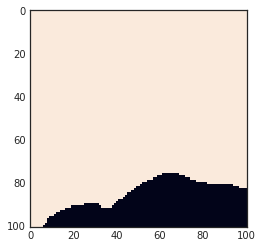

In [42]:
plt.imshow(np.squeeze(test_df["masks"][0] ))

In [43]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [44]:
rle_coded = [rle_encode(x) for x in test_df["masks"]]

In [45]:
test_df["rle_mask"] = rle_coded

In [46]:
test_df.head()

,masks,rle_mask
id,,
155410d6fa,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",1 706 708 99 809 97 910 96 1011 96 1112 95 121...
78b32781d1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",58 44 158 45 259 45 359 46 458 48 558 49 658 5...
63db2a476a,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",6760 7 6858 11 6957 13 7055 16 7154 18 7252 21...
17bfcdb967,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",4274 5 4357 5 4368 25 4401 3 4423 7 4435 9 445...
7ea0fd3c88,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",


In [47]:
submission = test_df.drop(columns="masks")

In [48]:
submission.to_csv("submission.csv")

In [20]:
checkpoint = torch.load("./checkpoints_lovasz/CP151.pth")

In [21]:
model.load_state_dict(checkpoint)

In [101]:
!mkdir checkpoints_lovasz

In [66]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

In [37]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)

NameError: name 'batch_size' is not defined

In [57]:
batch_size = 32
lr=0.001

In [73]:
loss = nn.BCELoss()

trainer = create_supervised_trainer(model,optimizer, loss)
evaluator = create_supervised_evaluator(model,
                                        metrics={
                                            'accuracy': CategoricalAccuracy(),
                                            'nll': Loss(loss)
                                        })

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    print("Epoch[{}] Loss: {:.2f}".format(trainer.state.epoch, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['nll']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(valid_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['nll']))

trainer.run(train_loader, max_epochs=200)